In [ ]:
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from scipy import stats
import plotly.express as px
import toml
import psrc_theme

%matplotlib inline
from IPython.display import display, HTML

# to show plotly figures in quarto HTML file
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
pio.templates.default = "simple_white+psrc_color" # set plotly template

input_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'input_configuration.toml'))
valid_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'validation_configuration.toml'))

# create connection
conn = create_engine('sqlite:///inputs/db/'+input_config['db_name'])

# summary data location
csv_path = os.path.join(valid_config['model_dir'], 'outputs/validation')

# table format
pd.options.display.float_format = '{:0,.2f}'.format
format_percent = "{:,.2%}".format

## transit boarding

### boarding by mode

In [5]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_mode.csv')).sort_values('observed_boardings', ascending=False)
plot_df = df.melt(id_vars=['mode'], value_vars=['observed_boardings', 'model_boardings'],
                  var_name='source', value_name='count')

In [7]:
table_df = df.copy()

table_df.loc['Total','observed_boardings'] = table_df['observed_boardings'].sum(axis=0)
table_df.loc['Total','model_boardings'] = table_df['model_boardings'].sum(axis=0)
table_df.loc['Total','mode'] = 'Total'
table_df['diff'] = table_df['model_boardings']-table_df['observed_boardings']
table_df['perc_diff'] = table_df['diff']/table_df['observed_boardings']
table_df[['observed_boardings','model_boardings','diff']] = table_df[['observed_boardings','model_boardings','diff']].astype('float')
table_df[['perc_diff']] = table_df[['perc_diff']].applymap(format_percent)
table_df = table_df.reset_index()
table_df

,index,mode,observed_boardings,model_boardings,diff,perc_diff
0,0,b,"332,640.45","381,275.18","48,634.73",14.62%
1,4,r,"81,991.16","61,321.53","-20,669.64",-25.21%
2,2,f,"14,116.21","28,001.45","13,885.24",98.36%
3,1,c,"6,354.00","9,803.42","3,449.42",54.29%
4,3,p,429.00,184.65,-244.35,-56.96%
5,Total,Total,"435,530.83","480,586.23","45,055.40",10.34%


### boarding by agency

In [2]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_agency.csv')).sort_values('observed_boardings', ascending=False)
plot_df = df.melt(id_vars=['agency'], value_vars=['observed_boardings', 'model_boardings'],
                  var_name='source', value_name='count')

In [3]:
table_df = df.copy()

table_df.loc['Total','observed_boardings'] = table_df.sum(axis=0).observed_boardings
table_df.loc['Total','model_boardings'] = table_df.sum(axis=0).model_boardings
table_df.loc['Total','agency'] = 'Total'
table_df['diff'] = table_df['model_boardings']-table_df['observed_boardings']
table_df['perc_diff'] = table_df['diff']/table_df['observed_boardings']
table_df[['observed_boardings','model_boardings','diff']] = table_df[['observed_boardings','model_boardings','diff']].astype('float')
table_df[['perc_diff']] = table_df[['perc_diff']].applymap(format_percent)
table_df = table_df.reset_index()
table_df

,index,agency,observed_boardings,model_boardings,diff,perc_diff
0,2,King County Metro,"253,313.62","338,485.37","85,171.75",33.62%
1,5,Sound Transit,"113,374.00","130,892.82","17,518.82",15.45%
2,0,Community Transit,"25,962.00","23,672.84","-2,289.16",-8.82%
3,4,Pierce Transit,"21,185.00","17,490.85","-3,694.15",-17.44%
4,6,Washington Ferries,"9,278.21","8,085.39","-1,192.82",-12.86%
5,3,Kitsap Transit,"8,258.00","16,539.82","8,281.82",100.29%
6,1,Everett Transit,"4,201.00","2,723.04","-1,477.96",-35.18%
7,Total,Total,"435,571.83","537,890.13","102,318.30",23.49%


In [4]:
# fig = px.bar(plot_df.sort_values('source'), x="agency", y="count",
#              color="source", barmode="group",
#              title="transit boardings by agency")
# fig.update_layout(height=400, width=700, font=dict(size=11),
#                   yaxis_tickformat = '.2f')
# fig.show()

### boarding by key route

In [5]:
df_boarding_key = pd.read_csv(os.path.join(csv_path,'daily_boardings_key_routes.csv'), index_col='description')
df_boarding_key[['observed_boardings','model_boardings']] = df_boarding_key[['observed_boardings','model_boardings']].astype('float')

df = df_boarding_key[df_boarding_key['route_code'].isin([4200,4201,4203,4204,5001,5002,5003,5004,5005,5006,5007,1973,1975])].reset_index()
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table

,description,observed_boardings,model_boardings,diff,perc_diff
0,973 W Sea Water Taxi,759.00,377.87,-381.13,-50.22%
1,975 Vashn Water Taxi,338.00,518.08,180.08,53.28%
2,Seattle-Bremerton FF,"1,913.00","5,133.84","3,220.84",168.37%
3,Brem-Pt Orchard FF,768.00,"1,376.79",608.79,79.27%
4,Seattle-Kingston FF,429.00,103.00,-326.00,-75.99%
5,Seattle-Southwrth FF,631.00,"1,057.31",426.31,67.56%
6,WSF Edmonds-Kingston,"1,500.13",231.44,"-1,268.69",-84.57%
7,WSF Seattle-Bain Isl,"5,513.69","5,845.79",332.10,6.02%
8,WSF Seattle-Brem,"1,188.97",235.79,-953.18,-80.17%
9,WSF Fauntleroy-Swrth,142.56,605.91,463.35,325.02%


r^2 : 0.8343863531735567


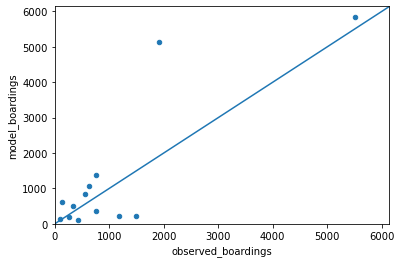

In [6]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings','model_boardings']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

##### bikes on ferry

In [7]:
df = pd.read_csv(os.path.join(csv_path,'bike_ferry_boardings.csv')).sort_values('@bvol', ascending=False)
df['route_code'] = df['route_code'].astype('int')
df[['route_code','description', '@bvol']]

,route_code,description,@bvol
4,4202,Brem-Annapolis FF,544.60
2,4200,Seattle-Bremerton FF,473.40
0,1973,973 W Sea Water Taxi,420.10
3,4201,Brem-Pt Orchard FF,402.30
5,4203,Seattle-Kingston FF,226.10
1,1975,975 Vashn Water Taxi,214.10
11,5005,WSF Fauntleroy-Vashn,205.70
12,5007,WSF Pt Def-Tahlequah,119.00
8,5002,WSF Seattle-Bain Isl,117.10
10,5004,WSF Fauntleroy-Swrth,49.40


In [8]:
df = df_boarding_key[df_boarding_key['route_code'].isin([6996,6999,6998])].reset_index()
df['description'] = df['route_code'].map({6998: 'Sounder South', 6999: 'Sounder North',6996: 'Link Red Line'})
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)

df_table

,description,observed_boardings,model_boardings,diff,perc_diff
0,Link Red Line,"79,522.00","64,788.28","-14,733.72",-18.53%
1,Sounder South,"6,038.00","8,642.67","2,604.67",43.14%
2,Sounder North,316.00,7.52,-308.48,-97.62%


r^2 : 0.9983044812080167


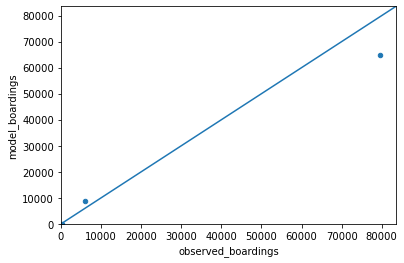

In [9]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings','model_boardings']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

In [10]:
df = df_boarding_key[df_boarding_key['route_code'].isin([1671,1672,1673,1674,1675,1676,6550,1007,1040,1997,1998])].reset_index()
df['description'] = df['route_code'].map({1671: 'A Line RapidRide', 1672: 'B Line RapidRide',
                                            1673: 'C Line RapidRide', 1674: 'D Line RapidRide',
                                            1675: 'E Line RapidRide', 1676: 'F Line RapidRide',
                                            6550: 'Sound Transit 550', 1040: 'KC Metro 40', 1007: 'KC Metro 7',
                                            1997: 'SLU Streetcar', 1998: 'First Hill Streetcar'})
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table.sort_values('model_boardings', ascending=False)

,description,observed_boardings,model_boardings,diff,perc_diff
6,E Line RapidRide,"11,426.00","17,860.54","6,434.54",56.31%
4,C Line RapidRide,"7,250.00","13,155.93","5,905.93",81.46%
0,KC Metro 7,"9,954.00","12,603.80","2,649.80",26.62%
1,KC Metro 40,"7,208.00","11,635.20","4,427.20",61.42%
5,D Line RapidRide,"9,044.00","10,032.32",988.32,10.93%
10,Sound Transit 550,"3,351.00","9,426.77","6,075.77",181.31%
2,A Line RapidRide,"8,412.00","7,197.27","-1,214.73",-14.44%
7,F Line RapidRide,"4,748.00","6,220.85","1,472.85",31.02%
3,B Line RapidRide,"4,177.00","4,242.31",65.31,1.56%
9,First Hill Streetcar,"3,900.45","1,701.56","-2,198.90",-56.38%


r^2 : 0.8322690169735353

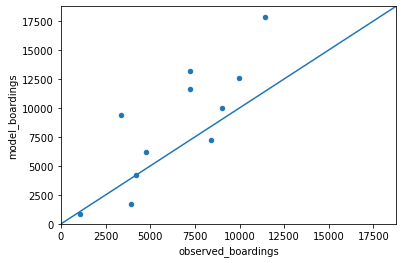

In [11]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings', 'model_boardings']].max().max() * 1.05
    ax.set_ylim(0, lim)
    ax.set_xlim(0, lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'], df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

### boarding on lines by agency

r^2 Community Transit: 0.9276436697742224
r^2 Everett Transit: 0.9778822822621337


r^2 King County Metro: 0.9338700242247481
r^2 Kitsap Transit: 0.9293450611191234
r^2 Pierce Transit: 0.7421755656106623


r^2 Sound Transit: 0.9883194590253195
r^2 Washington Ferries: 0.946708589710863


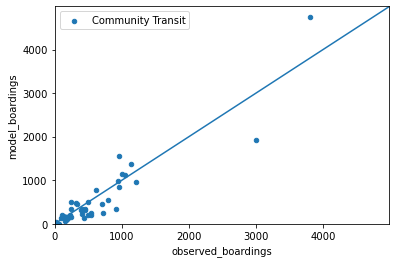

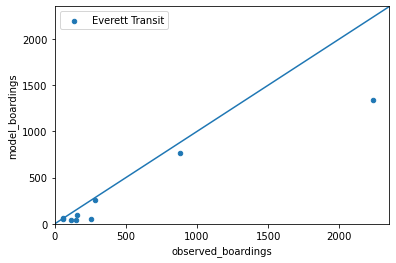

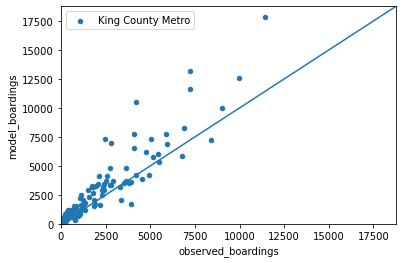

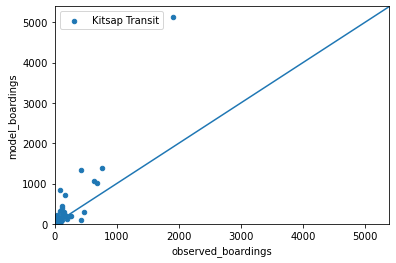

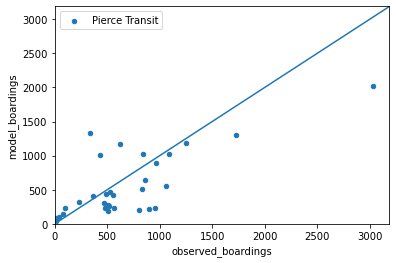

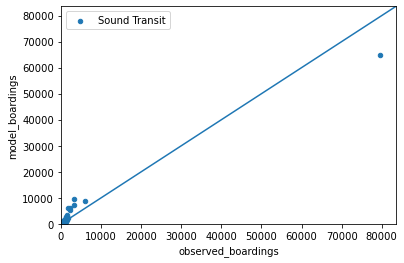

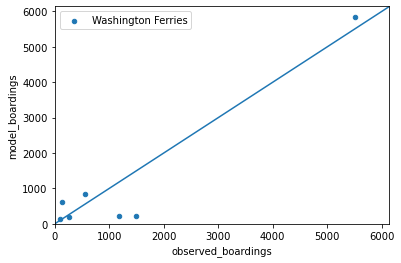

In [12]:
df = pd.read_csv(os.path.join(csv_path,'daily_boardings_by_line.csv'), index_col='agency')
df = df[-df['agency_id'].isnull()]

for agency in np.unique(df.index):
    _df = df.loc[agency,:]
    if (type(_df) == pd.core.frame.DataFrame) & (len(df) > 0):
        ax = _df.plot(kind='scatter', x='observed_boardings', y='model_boardings', label=agency)
        lim = _df[['observed_boardings','model_boardings']].max().max()*1.05
        ax.set_ylim(0,lim)
        ax.set_xlim(0,lim)
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x)
        slope, intercept, r_value, p_value, std_err = stats.linregress(_df['observed_boardings'],_df['model_boardings'])
        print('r^2 ' + str(agency) + ': ' + str(r_value))

### boarding by light rail station

In [13]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_boardings.csv'), index_col='station_name')
df['diff'] = df['model_boardings']-df['observed_boardings']
df['percent_diff'] = df['diff']/df['observed_boardings']

df_table = df.copy()
df_table[['percent_diff']] = df_table[['percent_diff']].applymap(format_percent)
df_table

,observed_boardings,model_boardings,diff,percent_diff
station_name,,,,
Husky Stadium,"6,134.00","3,573.53","-2,560.47",-41.74%
Westlake,"8,845.00","7,149.59","-1,695.41",-19.17%
University St,"4,324.00","4,919.81",595.81,13.78%
Pioneer Square,"2,400.00","4,660.17","2,260.17",94.17%
Int'l District,"4,399.00","1,641.32","-2,757.68",-62.69%
Capitol Hill,"7,667.00","5,345.01","-2,321.99",-30.29%
Stadium,"1,731.00",248.23,"-1,482.77",-85.66%
SODO,"1,669.00","1,857.23",188.23,11.28%
Beacon Hill,"2,147.00",897.96,"-1,249.04",-58.18%


In [14]:
df_combined = df.copy()

df_combined['station_group'] = df.index
df_combined.loc[['Westlake'],'station_group'] = 'Westlake/University St'
df_combined.loc[['University St'],'station_group'] = 'Westlake/University St'

df_combined.loc[['Pioneer Square'],'station_group'] = "Pioneer Square/Int'l District"
df_combined.loc[["Int'l District"],'station_group'] = "Pioneer Square/Int'l District"

df_combined.loc[['Stadium'],'station_group'] = 'Stadium/SODO'
df_combined.loc[['SODO'],'station_group'] = 'Stadium/SODO'

df_combined.loc[['Beacon Hill'],'station_group'] = 'Beacon Hill/Mount Baker'
df_combined.loc[['Mount Baker'],'station_group'] = 'Beacon Hill/Mount Baker'

df_combined.loc[['Othello'],'station_group'] = 'Othello/Rainier Beach'
df_combined.loc[['Rainier Beach'],'station_group'] = 'Othello/Rainier Beach'

df_combined = df_combined.groupby('station_group').sum()[['observed_boardings','model_boardings']]
df_combined['diff'] = df_combined['model_boardings']-df_combined['observed_boardings']
df_combined['percent_diff'] = df_combined['diff']/df_combined['observed_boardings']
df_combined[['percent_diff']] = df_combined[['percent_diff']].applymap(format_percent)

df_combined.loc[['Husky Stadium','Capitol Hill','Westlake/University St',"Pioneer Square/Int'l District",
                 'Stadium/SODO','Beacon Hill/Mount Baker','Columbia City','Othello/Rainier Beach',
                 "Tukwila Int'l Blvd",'SeaTac/Airport','Angle Lake']]

,observed_boardings,model_boardings,diff,percent_diff
station_group,,,,
Husky Stadium,"6,134.00","3,573.53","-2,560.47",-41.74%
Capitol Hill,"7,667.00","5,345.01","-2,321.99",-30.29%
Westlake/University St,"13,169.00","12,069.41","-1,099.59",-8.35%
Pioneer Square/Int'l District,"6,799.00","6,301.48",-497.52,-7.32%
Stadium/SODO,"3,400.00","2,105.46","-1,294.54",-38.07%
Beacon Hill/Mount Baker,"4,008.00","2,108.94","-1,899.06",-47.38%
Columbia City,"1,630.00","1,068.45",-561.55,-34.45%
Othello/Rainier Beach,"3,525.00","2,359.80","-1,165.20",-33.06%
Tukwila Int'l Blvd,"2,298.00","1,773.43",-524.57,-22.83%


### light rail stop transfers

In [15]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_transfers.csv'), index_col='station_name')
df[['percent_diff']] = df[['percent_diff']].applymap(format_percent)
df

,modeled_transfer_rate,observed_transfer_rate,diff,percent_diff
station_name,,,,
Husky Stadium,0.88,-99.00,99.88,-100.89%
Westlake,0.17,0.36,-0.19,-53.30%
University St,0.28,0.20,0.08,40.01%
Pioneer Square,0.46,0.16,0.30,191.17%
Int'l District,0.60,0.45,0.15,32.89%
Capitol Hill,0.07,-99.00,99.07,-100.07%
Stadium,0.43,0.12,0.31,262.52%
SODO,0.63,0.31,0.32,102.17%
Beacon Hill,0.44,0.35,0.08,23.73%
